# Sentiment Analysis: Large Movie Review Dataset

Hi again! You will be expected to finish this on your own, but you can use the available channels on Discord to ask questions and help others. Please read the entire notebook before starting, this will give you a better idea of what you need to accomplish.

This project is related to NLP. As you may already know, the most important and hardest part of an NLP project is pre-processing, which is why we are going to focus on that.

Regarding the data, we are not going to have a __csv file__, that would be too easy :) instead we are going to download the data from [AI Stanford Dataset](https://ai.stanford.edu/~amaas/data/sentiment/). When you download them you will notice that their format is text files, so you will have to work a little there to be able to use and process them. This is a dataset for __binary sentiment classification__.

Basically a basic sentiment analysis problem, as in this case, consists of a classification problem, where the possible output labels are: `positive` and `negative`. Which indicates, if the review of a movie speaks positively or negatively. In our case it is a binary problem, but one could have many more "feelings" tagged and thus allow a more granular analysis.

### These are the objectives of the project:

* Read data that is not in a traditional format.
* Put together a set of preprocessing functions that we can use later on any NLP or related problems.
* Vectorize the data in order to apply a machine learning model to it: using BoW or TF-IDF.
* BoW and TF-IDF are classic ways to vectorize text, but currently we have some more complex ways with better performance, for this we are going to train our own word embedding and use it as a vectorization source for our data.
* Train a sentiment analysis model that allows us to detect positive and negative opinions in movie reviews.

---
## 1. Get the data

#### Download the data and process it in order to obtain:

* `X_train:` list with reviews for training.
* `y_train:` list with labels for training.
* `X_test:` list with reviews for testing.
* `y_test:` list with labels for testing.

`Notes:` Use the target column as `positive`, that way the positive value will be indicated with a value of `1` and negative with a value of `0`. In this case, a split train/test is not necessary because the original data is already separated.

In [92]:
import os
import pandas as pd
import text_normalizer
import lightgbm as lgb
from evaluation import get_performance
from evaluation import plot_roc
import numpy as np
import xgboost as xgb
from text_normalizer import normalize_corpus
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from nltk.tokenize.toktok import ToktokTokenizer
%load_ext autoreload
%aimport evaluation
%autoreload 1
from gensim.models import Word2Vec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
def read_movie_review_dataset(directory, istrain): # Funtion to create the lists from the .txt files from the movies_reviews_dataset folder
    """
    Calls the walkdir funtion to walk through all the files in a directory and its subfolders,
    then it opens the .text file and reads its content. finally appends the .txt file content
    and label to the corresponding list.

    Parameters
    ----------
    directory : str
    Path to the folder you want to walk.

    Returns
    -------
    X_train: list with reviews for training.
    y_train: list with labels for training.
    X_test: list with reviews for testing.
    y_test: list with labels for testing..
    """
    train_folder = os.path.join(directory, "train")
    test_folder = os.path.join(directory, "test")
    X_train, y_train, X_train_unsup, X_test, y_test, = [], [], [], [], []
    if istrain==True:
        for dirpath, _, files in os.walk(train_folder):# Iterate over each file in 'train_folder' using os.walk
            for filename in files:
                full_path = os.path.join(dirpath, filename)
                pre_label = os.path.dirname(full_path)
                label = os.path.basename(pre_label)
                if label =='neg' or label=='pos':
                    file = open(full_path, 'rt', encoding="utf8")
                    movie_review = file.read()
                    file.close()
                    X_train.append(movie_review)
                    y_train.append(0 if label=='neg' else 1)
                if label == 'unsup':
                    file = open(full_path, 'rt', encoding="utf8")
                    movie_review = file.read()
                    file.close()
                    X_train_unsup.append(movie_review)
        return X_train, y_train, X_train_unsup
    else:
        for dirpath, _, files in os.walk(test_folder):# Iterate over each text in 'test_folder' using os.walk
            for filename in files:
                full_path = os.path.join(dirpath, filename)
                pre_label = os.path.dirname(full_path)
                label = os.path.basename(pre_label)
                if label =='neg' or label=='pos':
                    file = open(full_path, 'rt', encoding="utf8")
                    movie_review = file.read()
                    file.close()
                    X_test.append(movie_review)
                    y_test.append(0 if label=='neg' else 1)
        return X_test, y_test

In [94]:
# Calls the 'read_movie_review_dataset' funtion to create lists from the .txt files
X_train, y_train, X_train_unsup = read_movie_review_dataset('movie_reviews_dataset/', istrain=True)
X_test, y_test = read_movie_review_dataset('movie_reviews_dataset/', istrain=False)

In [95]:
# Creates .csv files of the moview reviews data
movie_reviews_dict = {'X_train': X_train, 'y_train': y_train,'X_test':X_test, 'y_test': y_test}
movie_reviews_dataframe = pd.DataFrame(movie_reviews_dict)
movie_reviews_dataframe.to_csv("movie_reviews_dataset.csv")

x_train_unsup_dict = {'X_train_unsup' : X_train_unsup}
x_train_unsup_dataframe = pd.DataFrame(x_train_unsup_dict)
x_train_unsup_dataframe.to_csv("x_train_unsup_dataset.csv")

In [96]:
movie_reviews_dataframe= pd.read_csv("movie_reviews_dataset.csv")
X_train = movie_reviews_dataframe['X_train'].tolist()
y_train = movie_reviews_dataframe['y_train'].tolist()
X_test = movie_reviews_dataframe['X_test'].tolist()
y_test = movie_reviews_dataframe['y_test'].tolist()

### *Don't change anything in this block, just make it run correctly*

We are going to check that you have done it right and for that we are going to see if the dimensions match.

In [97]:
def check_data(X_train, y_train, X_test, y_test):
    if len(X_train) == len(y_train) == len(X_test) == len(y_test) == 25000:
        print('Reading Data Success!')
    else:
        raise ValueError('Dimensions do not match!')

check_data(X_train, y_train, X_test, y_test)

Reading Data Success!


---
## 2. Normalize the data

#### Create the following functions but not here in the notebook, do it in the python script called `text_normalizer.py` and import them into the notebook (this way you can build your own NLP preprocessing library). In fact, the structure of the functions is already written, you must complete them with the code that you consider necessary.

#### Respect names and minimal interfaces:

* `remove_html_tags(text):` to remove all HTML tags that may be present in text.
* `remove_accented_chars(text):` to remove accented characters from text
* `expand_contractions(text):` to expand contractions of the type, "don't" to "do not". The contractions are already defined in the "contractions.py" file.
* `lemmatize_text(text):` to lemmatize text.
* `stem_text(text):` to apply stemming (NLTK's PorterStemmer) on text.
* `remove_special_chars(text):` to remove special characters from text.
* `remove_special_chars(text, remove_digits=True):` to remove numbers, note that it is the same function to remove special characters with the addition of an argument that enables or disables the removal of numbers.
* `remove_stopwords(text, stopwords=stop_words):` to remove stopwords from text.
* `remove_extra_new_lines(text):` to remove extra newlines from text.
* `remove_extra_whitespace(text):` to remove extra whitespaces from text.

If you want to add more features that would be great, for example you could start by removing emojis, using different stemming algorithms, etc. The more functions you have the better, remember that the texts are very varied and the preprocessing depends a lot on the source of our data.

To apply each of the functions you created and pre-process the dataset, you must use the `normalize_corpus` function of the `text_normalizer.py` script. In this method each of the functions you wrote is called, in fact you must enable or disable what you consider necessary (`at this point we leave it to your free choice, for example: you can lemmatize or apply stemming or directly not apply any of the two and so on with the rest, but that is your choice`), this function simply groups the previous ones for a more simplified use.

In [98]:
# Pre-procces X_train and X_Test the dataset using the normalize_corpus funtion from the text_normalizer script.
pre_proccesed_X_train = normalize_corpus(X_train, text_lemmatization=True,text_stemming=False)
pre_proccesed_X_train_unsup = normalize_corpus(X_train_unsup, text_lemmatization=True,text_stemming=False)
pre_proccesed_X_test = normalize_corpus(X_test, text_lemmatization=True,text_stemming=False)

100%|██████████| 25000/25000 [14:03<00:00, 29.64it/s]


In [99]:
# I turned the proccesed lists into a dataframe and then a csv file because it took long to create the proccesed lists 
x_train_x_test_dict_normalized = {'X_train_norm': pre_proccesed_X_train,'X_test_norm': pre_proccesed_X_test}
x_train_x_test_normalized_dataframe = pd.DataFrame(x_train_x_test_dict_normalized)
x_train_x_test_normalized_dataframe.to_csv("x_train_x_test_normalized.csv")

x_train_unsup_dict_normalized = {'X_train_unsup_norm': pre_proccesed_X_train_unsup}
x_train_unsup_normalized_dataframe = pd.DataFrame(x_train_unsup_dict_normalized)
x_train_unsup_normalized_dataframe.to_csv("x_train_unsup_normalized.csv") 

In [100]:
# Run this cell to get the proccesed lists from the '"x_train_x_test_normalized.csv"' from the project working folder
x_train_x_test_normalized_dataframe= pd.read_csv("x_train_x_test_normalized.csv")

In [101]:
# Run this cell to get the proccesed lists from the "x_train_unsup_normalized.csv" from the project working folder
x_train_unsup_normalized_dataframe = pd.read_csv("x_train_unsup_normalized.csv")

### *Don't change anything in this block, just make it run correctly*

We are going to check that the pre-processing does what we need it to do, for this we are going to test the functions with predefined inputs and we are going to see if the outputs match what we are looking for.

Note that the functions are not defined in the notebook itself, but rather that they are in a python file and you must import them in order to use them. Same thing with names, you're going to have to name your functions the way they were named.

In [102]:
import nltk

# Inputs
doc_html = "<br /><br />But with plague out there and the news being kept a secret, the New Orleans PD starts a dragnet of the city's underworld."
doc_accented = "Héllo, thís is an accented sénténce."
doc_contractions = "I can't, because it doesn't work."
doc_lemma = "The striped bats are hanging on their feet for best"
doc_stem = """
Where did he learn to dance like that?
His eyes were dancing with humor.
She shook her head and danced away.
"""
doc_specials = "hello? there A-Z-R_T(,**), world, welcome to python. this **should? the next line#followed- by@ an#other %million^ %%like $this."
doc_digits = "abc123def456ghi789zero0 hello my friend number 10"
doc_stop = "He is a very good person"
doc_new_lines = """we
use
a
lot
of
lines"""
doc_spaces = "Hello           my      dear          friend"

# Outputs
good_html = "But with plague out there and the news being kept a secret, the New Orleans PD starts a dragnet of the city's underworld."
good_accented = "Hello, this is an accented sentence."
good_contractions = "I cannot, because it does not work."
good_lemma = "the stripe bat be hang on their foot for good"
good_stem = "where did he learn to danc like that ? hi eye were danc with humor. she shook her head and danc away ."
good_specials = "hello there AZRT world welcome to python this should the next linefollowed by another million like this"
good_digits = "abcdefghizero hello my friend number "
good_stop = "good person"
good_new_lines = "we use a lot of lines"
good_spaces = "Hello my dear friend"
stop_words = nltk.corpus.stopwords.words('english')

def check_normalization():
    if good_html == text_normalizer.remove_html_tags(doc_html):
        print('[1/10] Remove HTML Success!')
    else:
        raise ValueError('[1/10] Remove HTML Fail!')
        
    if good_accented == text_normalizer.remove_accented_chars(doc_accented):
        print('[2/10] Remove Accented Success!')
    else:
        raise ValueError('[2/10] Remove Accented Fail!')
        
    if good_contractions == text_normalizer.expand_contractions(doc_contractions):
        print('[3/10] Expand Contractions Success!')
    else:
        raise ValueError('[3/10] Expand Contractions Fail!')
        
    if good_lemma == text_normalizer.lemmatize_text(doc_lemma):
        print('[4/10] Lemmatization Success!')
    else:
        raise ValueError('[4/10] Lemmatization Fail!')
        
    #print(text_normalizer.stem_text(doc_stem))
    if good_stem == text_normalizer.stem_text(doc_stem):
        print('[5/10] Stemming Success!')
    else:
        raise ValueError('[5/10] Stemming Fail!')
        
    if good_specials == text_normalizer.remove_special_chars(doc_specials):
        print('[6/10] Remove Specials Success!')
    else:
        raise ValueError('[6/8] Remove Specials Fail!')
        
    if good_digits == text_normalizer.remove_special_chars(doc_digits, remove_digits=True):
        print('[7/10] Remove Digits Success!')
    else:
        raise ValueError('[7/10] Remove Digits Fail!')
        
    if good_stop == text_normalizer.remove_stopwords(doc_stop, stopwords=stop_words):
        print('[8/10] Remove Stopwords Success!')
    else:
        raise ValueError('[8/10] Remove Stopwords Fail!')
    
    if good_new_lines == text_normalizer.remove_extra_new_lines(doc_new_lines):
        print('[9/10] Remove New Lines Success!')
    else:
        raise ValueError('[9/10] Remove New Lines Fail!')
        
    if good_spaces == text_normalizer.remove_extra_whitespace(doc_spaces):
        print('[10/10] Remove Extra Whitespaces Success!')
    else:
        raise ValueError('[10/10] Remove Extra Whitespaces Fail!')

check_normalization()

[1/10] Remove HTML Success!
[2/10] Remove Accented Success!
[3/10] Expand Contractions Success!
[4/10] Lemmatization Success!
[5/10] Stemming Success!
[6/10] Remove Specials Success!
[7/10] Remove Digits Success!
[8/10] Remove Stopwords Success!
[9/10] Remove New Lines Success!
[10/10] Remove Extra Whitespaces Success!


---
## 3. Feature Engineering

You already have the pr-eprocessed data, now you must vectorize them, because remember that the models only understand numbers. At this stage choose whether you want to vectorize with BoW or with TF-IDF. Later we will train our own embedding but for now we go with a more "classic" vectorization.

In [103]:
vectorizer = TfidfVectorizer(norm= None)
x_train_vectorized = vectorizer.fit_transform(x_train_x_test_normalized_dataframe['X_train_norm'].tolist())
x_test_vectorized = vectorizer.transform(x_train_x_test_normalized_dataframe['X_test_norm'].tolist())

## 4. Modeling and Performance Evaluation

As we said at the beginning, what interests us most in this part is pre-processing. However, we must train a model, so choose a model of your choice (obviously a classification model, given the problem we are facing) and apply everything we learned. Also if you want you can try several models, the more models you use and know better!

In addition to training the model we ask you to show:

* `Precision`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`

To do this you must complete the `get_performance` function of the `evaluation.py` script.

Also, you must complete the `plot_roc` function so that it can show:

* `ROC Curve`
* `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

In [104]:
# Logistic Regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], "max_iter":[100000], "tol":[0.0010, 0.0012]}
logreg = LogisticRegression(random_state=2611)
clf_cv = GridSearchCV(logreg,grid,cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
logreg_cv = clf_cv.fit(x_train_vectorized,y_train)
y_logreg_cv_pred = logreg_cv.predict(x_test_vectorized)
print("Logistic regression tuned hpyerparameters :(best parameters) ",logreg_cv.best_estimator_.get_params())

Fitting 5 folds for each of 28 candidates, totalling 140 fits


c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint6-gza19SlD-py3.8\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint6-gza19SlD-py3.8\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint6-gza19SlD-py3.8\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _c

Logistic regression tuned hpyerparameters :(best parameters)  {'C': 0.001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 2611, 'solver': 'lbfgs', 'tol': 0.001, 'verbose': 0, 'warm_start': False}


In [105]:
get_performance(y_logreg_cv_pred,y_test)
y_pred_proba_test_lr = logreg_cv.predict_proba(x_test_vectorized)[::,1]
auc_test_lr = metrics.roc_auc_score(y_test, y_pred_proba_test_lr)

y_pred_proba_train_lr = logreg_cv.predict_proba(x_train_vectorized)[::,1]
auc_train_lr = metrics.roc_auc_score(y_test, y_pred_proba_train_lr)

print('Roc AUC Logistic Regression Training set score: {:.4f}'.format(auc_train_lr))
print('Roc AUC Logistic Regression Test set score: {:.4f}'.format(auc_test_lr))

Model Performance metrics:
------------------------------
Accuracy: 0.8768
Precision: 0.8806983511154219
Recall: 0.87168
F1 Score: 0.8761659697651979

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.88      0.88     12500
           1       0.88      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  11024   1476
1   1604  10896
Roc AUC Logistic Regression Training set score: 0.9922
Roc AUC Logistic Regression Test set score: 0.9443


In [106]:
# RandomForest Classifier
model_params = {
    # Number of trees in random forest
    'n_estimators': [int(x) for x in np.linspace(start = 4, stop = 200, num = 4)],
    # Maximum number of levels in tree
    'max_depth': [20, 40, 60, 100],
    # Minimum number of samples required to split a node - itereate 3 different values
    'min_samples_split': [2, 5, 10],
    # Minimum number of samples required at each leaf node - itereate 3 different values
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier(random_state=2611, verbose=1)
clf_randomcv = RandomizedSearchCV(rf_model, model_params, n_iter=20, cv=3, random_state=2611, n_jobs=-1, verbose=1, scoring='roc_auc')
rf_randomcv = clf_randomcv.fit(x_train_vectorized,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   20.7s finished


In [107]:
y_rf_predict_cv = rf_randomcv.predict(x_test_vectorized)
get_performance(y_rf_predict_cv,y_test)
y_pred_proba__test_RandomForest = rf_randomcv.predict_proba(x_test_vectorized)[::,1]
auc_test_RandomForest = metrics.roc_auc_score(y_test, y_pred_proba__test_RandomForest)

y_pred_proba_train_RandomForest = rf_randomcv.predict_proba(x_train_vectorized)[::,1]
auc_train_RandomForest = metrics.roc_auc_score(y_test, y_pred_proba_train_RandomForest)

print('Roc AUC Random Forest Training set score: {:.4f}'.format(auc_train_RandomForest))
print('Roc AUC Random Forest Test set score: {:.4f}'.format(auc_test_RandomForest))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model Performance metrics:
------------------------------
Accuracy: 0.85936
Precision: 0.8500623441396509
Recall: 0.87264
F1 Score: 0.8612032212221695

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     12500
           1       0.85      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10576   1924
1   1592  10908


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Roc AUC Random Forest Training set score: 0.9812
Roc AUC Random Forest Test set score: 0.9350


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.5s finished


In [108]:
# XGBoost Classifier
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=2611, learning_rate=0.1, n_jobs=-1, n_estimators = 1000)
xgb_model.fit(x_train_vectorized,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=2611, ...)

In [109]:
y_xgbf_predict = xgb_model.predict(x_test_vectorized)
get_performance(y_xgbf_predict,y_test)

y_pred_proba_test_xgb = xgb_model.predict_proba(x_test_vectorized)[::,1]
auc_test_xgb = metrics.roc_auc_score(y_test, y_pred_proba_test_xgb)

y_pred_proba_train_xgb = xgb_model.predict_proba(x_train_vectorized)[::,1]
auc_train_xgb = metrics.roc_auc_score(y_test, y_pred_proba_train_xgb)

print('Roc AUC Gradient Boosting Training set score: {:.4f}'.format(auc_train_xgb))
print('Roc AUC Gradient Boosting Test set score: {:.4f}'.format(auc_test_xgb))

Model Performance metrics:
------------------------------
Accuracy: 0.87092
Precision: 0.8653376408478449
Recall: 0.87856
F1 Score: 0.8718986939780079

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.87      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10791   1709
1   1518  10982
Roc AUC Gradient Boosting Training set score: 0.9987
Roc AUC Gradient Boosting Test set score: 0.9446


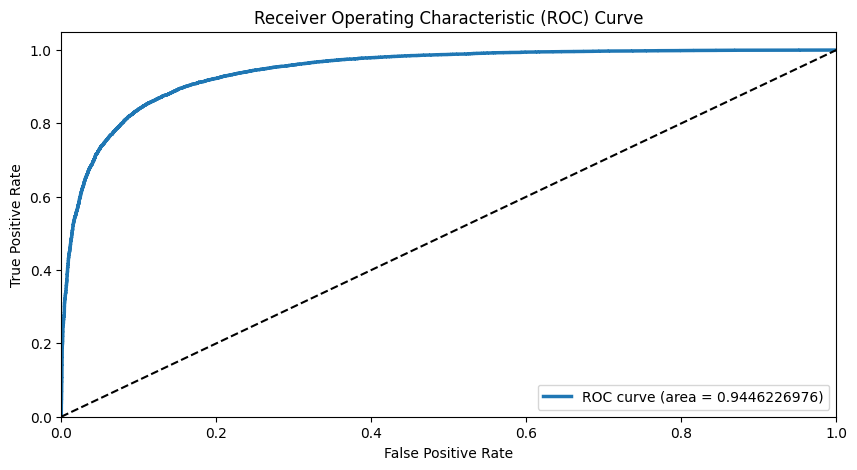

In [110]:
roc_auc = plot_roc(xgb_model, y_test, x_test_vectorized)

### *Don't change anything in this block, just make it run correctly*

Let's check that the `get_performance` function returns the metrics correctly. For that we are going to simulate input/output data of a model.

In [111]:
def check_basic_metrics():
    accuracy, precision, recall, f1_score = get_performance(
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0], 
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
    )
    
    if (accuracy, precision, recall, f1_score) == (0.6, 0.6, 0.6, 0.6):
        print('Success!')
    else:
        raise ValueError('You must check your get_performance function!')
        
check_basic_metrics()

Model Performance metrics:
------------------------------
Accuracy: 0.6
Precision: 0.6
Recall: 0.6
F1 Score: 0.6

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.60      0.60      0.60         5

    accuracy                           0.60        10
   macro avg       0.60      0.60      0.60        10
weighted avg       0.60      0.60      0.60        10


Prediction Confusion Matrix:
------------------------------
   0  1
0  3  2
1  2  3
Success!


Let's see if your model at least exceeds an ROC-AUC of 0.93

In [112]:
def check_roc(roc_auc):
    if roc_auc > 0.93:
        print('Success!')
    else:
        raise ValueError('Your model is not good enough!')
        
check_roc(roc_auc)

Success!


---
## 5. Feature Engineering with Custom Word Embedding

### Tokenize reviews and train your own Word Embedding

You are going to have to train your own word embedding, for this we are going to use the __gensim__ library. The only requirement we ask of you is that the $vector\_size=100$.

[Here](https://radimrehurek.com/gensim/models/word2vec.html) you can read Gensim's Word2Vec documentation so you can train your own embedding, using the review data as a corpus.

As a previous step to training your word embedding you must tokenize the corpus, this may take a bit depending on the size of the dataset and the tokenizer we use, if you want you can try the NLTK tokenizer called `ToktokTokenizer`, which turns out to be a little faster (we hope that this recommendation does not bias your work, try and use the ones you want)

In [113]:
def tokenize_corpus(corpus):
    tokenizer = ToktokTokenizer()
    tokenized_corpus = [tokenizer.tokenize(text) for text in corpus] 
    return tokenized_corpus

In [114]:
X_train_tokenized = tokenize_corpus(x_train_x_test_normalized_dataframe['X_train_norm'].tolist())
X_train_unsup_tokenized = tokenize_corpus(x_train_unsup_normalized_dataframe['X_train_unsup_norm'].tolist())
X_test_tokenized = tokenize_corpus(x_train_x_test_normalized_dataframe['X_test_norm'].tolist())

In [115]:
X_train_extended = X_train_tokenized  + X_train_unsup_tokenized

In [116]:
model_w2vec = Word2Vec(X_train_extended, vector_size=100, window=18, min_count=5, workers=8)

### Generate averaged word vector features

Once the embedding has been trained, we must use it. Remember that embedding will convert each word you pass to it into a vector of a given dimension (in our case $vector\_size=100$). So in order to obtain a vector for each review, you must average the vectors of all the words that are part of the same review.

The function must have the following form:
* `vectorizer(corpus, model, num_features=100)`


Where:
* `corpus:` corresponds to the entire dataset, in this way we obtain an average vector for each review, with a single call to the function.
* `model:` is your trained model.
* `num_features:` the dimension of the output vector of your embedding (remember that in our case we set this value to 100).

In [117]:
def vectorizer(corpus, model, num_features=100):
    # Put your code
    corpus_vectors = []
    vocab = set(model.wv.index_to_key)
    for text in corpus:
        text_vector=[]
        for word in text:
            if word in vocab:
                word_vector = model.wv[word]
                text_vector.append(word_vector)
        avg_vector = np.array(text_vector).mean(axis=0)
        corpus_vectors.append(avg_vector)
    return corpus_vectors

In [118]:
X_train_w2vec = vectorizer(X_train_tokenized, model_w2vec)
X_test_w2vec = vectorizer(X_test_tokenized, model_w2vec)

### *Don't change anything in this block, just make it run correctly*

Let's do a simple check of the embedding that you just trained.

In [119]:
def check_embedding(model):
    vector = model.wv['computer']
    if len(vector) == 100:
        print(
            'Success! Your embedding tells me that "women" and "man" '
            f'are similar with a score of {model.wv.similarity("woman", "man")}'
        )
    else:
        raise ValueError('You should check your embedding vector size!')
        
check_embedding(model_w2vec)

Success! Your embedding tells me that "women" and "man" are similar with a score of 0.5764694809913635


Now, we are going to check the vectorizer, remember that the vectorizer must generate an average vector of all the words present in the same review. So we're going to get two vectors of two words and manually average them, then using those two words we'll simulate a tokenized sentence and see that it matches the manual way.

In [120]:
def check_vectorizer(model):
    vector1 = model.wv['personal']
    vector2 = model.wv['computer']
    avg = vectorizer([['personal', 'computer']], model)[0]

    if np.allclose((vector1 + vector2) / 2, avg):
        print('Success!')
    else:
        raise ValueError('You should check your vectorizer!')
        
check_vectorizer(model_w2vec)

Success!


### Modeling

Finally train a new model, it can be the same one you used before and compare the results you got using BoW/TF-IDF and Word2Vec.

In addition to training the model we ask you to show:

* `Accuracy`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`
* `ROC Curve`
* `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

In [121]:
# Logistic Regression
grid_lg_w2vec={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], "max_iter":[100000], "tol":[0.0010, 0.0012]}
logreg_w2vec = LogisticRegression(random_state=2611)
clf_w2vec_cv = GridSearchCV(logreg_w2vec,grid_lg_w2vec,cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
logreg_w2vec_cv = clf_w2vec_cv.fit(X_train_w2vec,y_train)
y_logreg_w2vec_cv_pred = logreg_w2vec_cv.predict(X_test_w2vec)
print("Logistic regression tuned hpyerparameters :(best parameters) ",logreg_w2vec_cv.best_estimator_.get_params())

Fitting 5 folds for each of 28 candidates, totalling 140 fits


c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint6-gza19SlD-py3.8\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint6-gza19SlD-py3.8\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint6-gza19SlD-py3.8\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _c

Logistic regression tuned hpyerparameters :(best parameters)  {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 2611, 'solver': 'lbfgs', 'tol': 0.001, 'verbose': 0, 'warm_start': False}


In [122]:
get_performance(y_logreg_w2vec_cv_pred,y_test)

y_pred_proba_test_lrw2vec = logreg_w2vec_cv.predict_proba(X_test_w2vec)[::,1]
auc_test_lrw2vec = metrics.roc_auc_score(y_test, y_pred_proba_test_lrw2vec)

y_pred_proba_train_lrw2vec = logreg_w2vec_cv.predict_proba(X_train_w2vec)[::,1]
auc_train_lrw2vec = metrics.roc_auc_score(y_test, y_pred_proba_train_lrw2vec)

print('Roc AUC Logistic Regression Training set score: {:.4f}'.format(auc_train_lrw2vec))
print('Roc AUC Logistic Regression Test set score: {:.4f}'.format(auc_test_lrw2vec))

Model Performance metrics:
------------------------------
Accuracy: 0.86544
Precision: 0.8631737955159803
Recall: 0.86856
F1 Score: 0.8658585214131908

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     12500
           1       0.86      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10779   1721
1   1643  10857
Roc AUC Logistic Regression Training set score: 0.9355
Roc AUC Logistic Regression Test set score: 0.9379


In [123]:
# RandomForest Classifier
model_params = {
    # Number of trees in random forest
    'n_estimators': [int(x) for x in np.linspace(start = 4, stop = 200, num = 4)],
    # Maximum number of levels in tree
    'max_depth': [20, 40, 60, 100],
    # Minimum number of samples required to split a node - itereate 3 different values
    'min_samples_split': [2, 5, 10],
    # Minimum number of samples required at each leaf node - itereate 3 different values
    'min_samples_leaf': [1, 2, 4]
}
rf_model_w2vec = RandomForestClassifier(random_state=2611, verbose=1)
clf_randomcv_w2vec = RandomizedSearchCV(rf_model_w2vec, model_params, n_iter=20, cv=3, random_state=2611, n_jobs=-1, verbose=1, scoring='roc_auc')
rf_randomcv_w2vec = clf_randomcv_w2vec.fit(X_train_w2vec,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   37.2s finished


In [124]:
y_rf_w2vec_cv_pred = rf_randomcv_w2vec.predict(X_test_w2vec)
get_performance(y_rf_w2vec_cv_pred,y_test)

y_pred_proba_test_RF_w2vec = rf_randomcv_w2vec.predict_proba(X_test_w2vec)[::,1]
auc_test_RF_w2vec = metrics.roc_auc_score(y_test, y_pred_proba_test_RF_w2vec)

y_pred_proba_train_RF_w2vec = rf_randomcv_w2vec.predict_proba(X_train_w2vec)[::,1]
auc_train_RF_w2vec = metrics.roc_auc_score(y_test, y_pred_proba_train_RF_w2vec)

print('Roc AUC Random Forest Training set score: {:.4f}'.format(auc_train_RF_w2vec))
print('Roc AUC Random Forest Test set score: {:.4f}'.format(auc_test_RF_w2vec ))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model Performance metrics:
------------------------------
Accuracy: 0.838
Precision: 0.8294603867747973
Recall: 0.85096
F1 Score: 0.8400726583478123

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     12500
           1       0.83      0.85      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10313   2187
1   1863  10637


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Roc AUC Random Forest Training set score: 0.9993
Roc AUC Random Forest Test set score: 0.9170


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


In [125]:
# XGBoost Classifier
xgb_model_w2vec = xgb.XGBClassifier(objective="binary:logistic", random_state=2611, learning_rate=0.1, n_jobs=-1, n_estimators = 1000)
xgb_model_w2vec.fit(X_train_w2vec,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=2611, ...)

In [126]:
y_xgbf_predict_w2vec = xgb_model_w2vec.predict(X_test_w2vec)
get_performance(y_xgbf_predict_w2vec,y_test)

y_pred_proba_test_xgb = xgb_model_w2vec.predict_proba(X_test_w2vec)[::,1]
auc_test_xgb_w2vec = metrics.roc_auc_score(y_test, y_xgbf_predict_w2vec)

y_pred_proba_train_xgb =xgb_model_w2vec.predict_proba(X_train_w2vec)[::,1]
auc_train_xgb_w2vec = metrics.roc_auc_score(y_test, y_xgbf_predict_w2vec)

print('Roc AUC Gradient Boosting Training set score: {:.4f}'.format(auc_train_xgb_w2vec))
print('Roc AUC Gradient Boosting Test set score: {:.4f}'.format(auc_test_xgb_w2vec))

Model Performance metrics:
------------------------------
Accuracy: 0.86088
Precision: 0.8611689351481185
Recall: 0.86048
F1 Score: 0.8608243297318928

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     12500
           1       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10766   1734
1   1744  10756
Roc AUC Gradient Boosting Training set score: 0.8609
Roc AUC Gradient Boosting Test set score: 0.8609


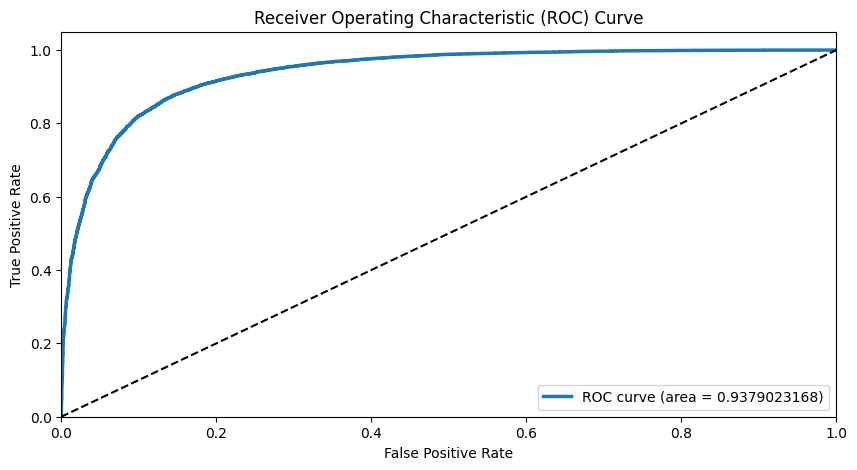

In [127]:
roc_auc = plot_roc(logreg_w2vec_cv, y_test, X_test_w2vec)

### *Don't change anything in this block, just make it run correctly*

In [128]:
check_roc(roc_auc)

Success!


---
### OPTIONAL:

In our case, we train a word embedding from scratch, which is very good at an educational level, but when applying it to a real problem, we need a lot of data (which is not the case with our problem). Therefore, we invite you to investigate and use one of the `pre-trained Word2Vec models`.

If you look for the `Pretrained models` section in this [link](https://radimrehurek.com/gensim/models/word2vec.html), you will find information about the models that Gensim owns.

In [129]:
import gensim.downloader as api

In [130]:
model_pre_trained_w2vec = api.load('glove-twitter-100')

In [131]:
def vectorizer(corpus, model, num_features=100):
    # Put your code
    corpus_vectors = []
    vocab = set(model.index_to_key)
    for text in corpus:
        text_vector=[]
        for word in text:
            if word in vocab:
                word_vector = model[word]
                text_vector.append(word_vector)
        avg_vector = np.array(text_vector).mean(axis=0)
        corpus_vectors.append(avg_vector)
    return corpus_vectors

In [132]:
X_train_w2vec_pt = vectorizer(X_train_tokenized, model_pre_trained_w2vec)
X_test_w2vec_pt = vectorizer(X_test_tokenized, model_pre_trained_w2vec)

In [133]:
# Logistic Regression (word2vec pre-trained model)
grid_lg_w2vec_pt={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], "max_iter":[100000], "tol":[0.0010, 0.0012]}
logreg_w2vec_pt = LogisticRegression(random_state=2611)
clf_w2vec_cv_pt = GridSearchCV(logreg_w2vec_pt,grid_lg_w2vec_pt,cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
logreg_w2vec_cv_pt = clf_w2vec_cv_pt.fit(X_train_w2vec_pt,y_train)
y_logreg_w2vec_cv_pred_pt = logreg_w2vec_cv_pt.predict(X_test_w2vec_pt)
print("Logistic regression tuned hpyerparameters :(best parameters) ",logreg_w2vec_cv.best_estimator_.get_params())

Fitting 5 folds for each of 28 candidates, totalling 140 fits


c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint6-gza19SlD-py3.8\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint6-gza19SlD-py3.8\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint6-gza19SlD-py3.8\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _c

Logistic regression tuned hpyerparameters :(best parameters)  {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 2611, 'solver': 'lbfgs', 'tol': 0.001, 'verbose': 0, 'warm_start': False}


In [134]:
get_performance(y_logreg_w2vec_cv_pred_pt,y_test)

y_pred_proba_test_lrw2vec_pt = logreg_w2vec_cv_pt.predict_proba(X_test_w2vec_pt)[::,1]
auc_test_lrw2vec_pt = metrics.roc_auc_score(y_test, y_pred_proba_test_lrw2vec_pt)

y_pred_proba_train_lrw2vec_pt = logreg_w2vec_cv_pt.predict_proba(X_train_w2vec_pt)[::,1]
auc_train_lrw2vec_pt = metrics.roc_auc_score(y_test, y_pred_proba_train_lrw2vec_pt)

print('Roc AUC Logistic Regression Training set score: {:.4f}'.format(auc_train_lrw2vec_pt))
print('Roc AUC Logistic Regression Test set score: {:.4f}'.format(auc_test_lrw2vec_pt))

Model Performance metrics:
------------------------------
Accuracy: 0.80716
Precision: 0.8136590147863737
Recall: 0.7968
F1 Score: 0.8051412634897539

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.80      0.82      0.81     12500
           1       0.81      0.80      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000


Prediction Confusion Matrix:
------------------------------
       0     1
0  10219  2281
1   2540  9960
Roc AUC Logistic Regression Training set score: 0.8913
Roc AUC Logistic Regression Test set score: 0.8883


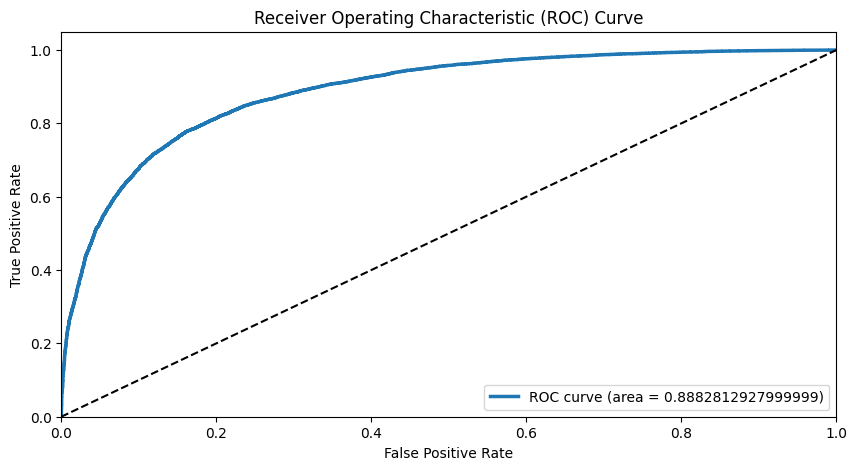

In [136]:
roc_auc = plot_roc(logreg_w2vec_cv_pt, y_test, X_test_w2vec_pt)